# PSF profile

This notebook is a little digression on looking at the radial profile of the PSFs computed in this project with PSFEx.

In [1]:
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm
from matplotlib import patheffects
from astropy.io import fits
import astropy.units as u
from photutils.profiles import RadialProfile
import dja_sepp
from dja_sepp.utils import color_dict, channel_dict, channel_color_dict, filters_waveband

plt.rcParams['xtick.labelsize']='large'
plt.rcParams['ytick.labelsize']='large'
plt.rcParams['axes.labelsize']='x-large'
plt.rcParams['legend.fontsize']='medium'
plt.rcParams['xtick.top']=True
plt.rcParams['ytick.right']=True
plt.rcParams['xtick.direction']='in'
plt.rcParams['ytick.direction']='in'
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['ytick.minor.visible']=True
# %matplotlib ipympl

First, we load the different PSFs file (here done automatically).

In [2]:
home = "/home/aurelien/DAWN/DJA-SEpp"
field = 'GDS'
psf_list = glob.glob(f"{home}/fields/{field}/psfex/*star_psf.psf")
filter_list = [re.search("f{1}\d+\w{1}",psf).group() for psf in psf_list]
psf_list, filter_list = zip(*sorted(zip(psf_list, filter_list)))

Then we show the different PSFs.

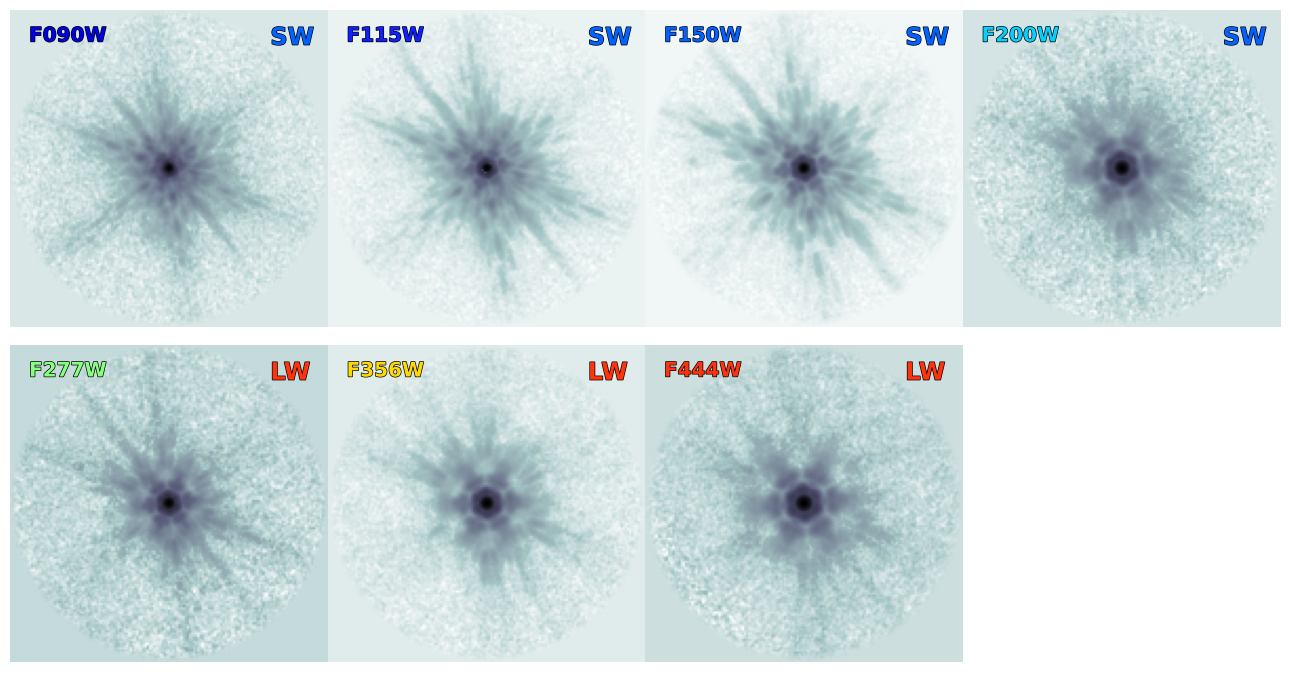

In [3]:
# Auto-sized plot to display all the PSFs
def psf_plot(ax, filter):
    with fits.open(psf_list[filter_list.index(filter)]) as image:
        psf = image[1].data[0][0][0]
    ax.set_axis_off()
    ax.imshow(psf, origin='lower', cmap='bone_r', norm=SymLogNorm(linthresh=1e-5, linscale=0.8))
    ax.text(0.06, 0.9, filter.upper(), transform=ax.transAxes, 
            fontsize='x-large', fontweight='bold', 
            color=color_dict[filter.upper()],
            path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])
    ax.text(0.82, 0.89, channel_dict[filter.upper()], transform=ax.transAxes, 
            fontsize='xx-large', fontweight='bold', 
            color=channel_color_dict[channel_dict[filter.upper()]],
            path_effects=[patheffects.withStroke(linewidth=1, foreground="k")])

fig, ax = dja_sepp.utils.plot_group_filter(filter_list, psf_plot)
fig.tight_layout()
# fig.savefig(f"{home}/fields/{field}/psfex/PSF_summary_{field}.pdf", bbox_inches='tight', pad_inches=0)
# fig.savefig(f"{home}/fields/{field}/psfex/PSF_summary_{field}.png", bbox_inches='tight', pad_inches=0, dpi=100)
plt.show()

Here we compute the radial profile for each PSF using `photutils`.

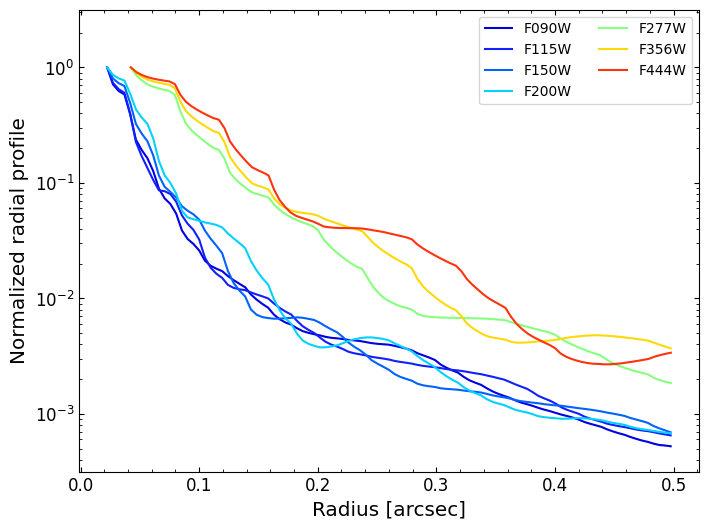

In [4]:
pixel_size = {'SW': 0.02*u.arcsec, 'LW': 0.04*u.arcsec} # arcsec/px

FWHM = {'wavelength':[], 'fwhm':[], 'fwhm_psfex':[]}

fig, ax = plt.subplots(figsize=(8,6))
for i, filter in enumerate(filter_list):
    image = fits.open(psf_list[i])
    psf = image[1].data[0][0][0]
    FWHM['fwhm_psfex'].append(image[1].header['PSF_FWHM']*pixel_size[channel_dict[filter.upper()]].value)
    image.close()
    radii = np.linspace(pixel_size[channel_dict[filter.upper()]].value,0.5,100)*u.arcsec
    radii_px = (radii/pixel_size[channel_dict[filter.upper()]]).value
    rp = RadialProfile(psf, [psf.shape[0]/2, psf.shape[1]/2], radii_px)
    rp.normalize()
    FWHM['fwhm'].append(rp.gaussian_fwhm*pixel_size[channel_dict[filter.upper()]].value)
    FWHM['wavelength'].append(filters_waveband[filter.upper()]['pivot'])
    ax.plot(rp.radius*pixel_size[channel_dict[filter.upper()]].value, rp.profile, color=color_dict[filter.upper()], label=filter.upper())

ax.set_yscale('log')
ax.set_ylim(10**-3.5,10**0.5)
ax.set_xlabel("Radius [arcsec]")
ax.set_ylabel("Normalized radial profile")
ax.legend(loc='upper right', ncol=2)
plt.show()

Finally, we can look at the FWHM for each band, and plot them as a function of the pivot wavelength for each band.

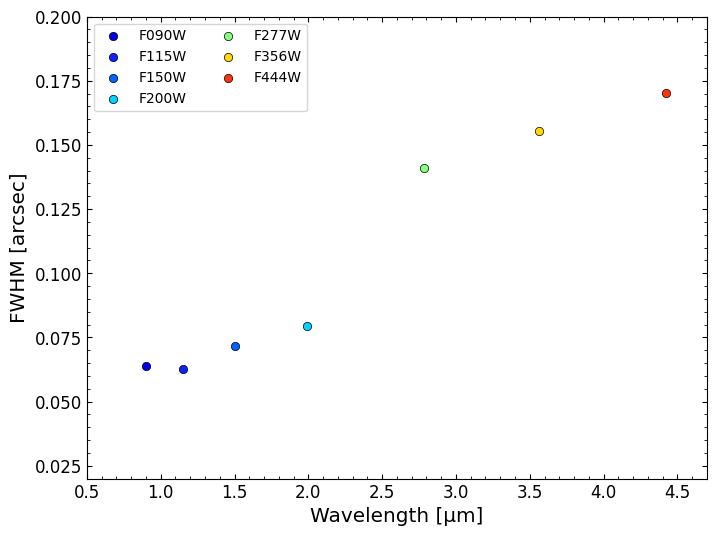

In [5]:
fig, ax = plt.subplots(figsize=(8,6))
for i, filter in enumerate(filter_list):
    ax.scatter(FWHM['wavelength'][i], FWHM['fwhm'][i], color=color_dict[filter.upper()], edgecolors='k', lw=0.5, label=filter.upper())

ax.set_xlabel("Wavelength [µm]")
ax.set_ylabel("FWHM [arcsec]")
ax.set_ylim(0.02,0.2)
ax.set_xlim(0.5,4.7)
ax.legend(loc='upper left', ncol=2)
plt.show()